**관련 Github Preview**   
- **DistilBERT 감정 분석 모델 실습 코드 분석 - Binary Classification**   
[![Notebook](https://img.shields.io/badge/Github-Preview-black?logo=github)](https://github.com/zerovodka/ML-learning/blob/master/src/week3/DistilBERT-study.ipynb)
- **About AG_News Dataset**   
[![Notebook](https://img.shields.io/badge/Github-Preview-black?logo=github)](https://github.com/zerovodka/ML-learning/blob/master/src/week3/AG_News.ipynb)

# DistilBERT - 기본

> 뉴스 기사 분류 모델 학습하기 (Multi-Class Classification)

- pre-trained DistilBERT를 뉴스 기사 분류 문제에 적용

<br>

**과제 목표**   
- AG_News 데이터셋 사용, train/test 각 5%만 사용
- `collate_fn`에서 `truncation`제거
- **Multi-Class Classification** task -> `CrossEntropyLoss` 적용, `Linear` output dimension 수정
- `accuracy` 함수 argmax 처리
- 학습 결과 출력 및 시각화
  - epoch 마다 `train loss` 출력
  - `test accuracy` report & plot

**과제 목표 요약**   

|항목|	기존코드|	수정내용|
|:------|:------|:------|
|데이터셋	|IMDB (binary)	|AG_News (4 classes)
|tokenizer|	HuggingFace DistilBERT|	그대로 사용
|collate_fn|	`truncation=True`|	❌ 제거
|classifier	|`Linear(768, 1)`|	🔁 `Linear(768, 4)`
|loss	|`BCEWithLogitsLoss`	|🔁 `CrossEntropyLoss`
|accuracy	|`(preds > 0)`	|🔁 `argmax(preds)`
|출력	|train loss만 출력|	🔁 test accuracy + 시각화

### Packages
- `datasets`: HuggingFace의 데이터셋 로더

In [ ]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

### Libraries
- `load_dataset`: HuggingFace 데이터셋을 쉽게 불러오기 위한 함수

### Tokenizer
- `tokenizer`: DistilBERT용 토크나이저
  - `distilbert-base-uncased`: 소문자만 사용하는 경량 BERT 모델

In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

# DistilBERT 모델용 tokenizer 로드 (pretrained)
# 이 tokenizer는 문장을 토큰화해서 모델이 이해할 수 있는 input_ids로 변환해줌
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### 데이터셋 불러오기(`load_dataset`)
**데이터셋**   
- **AG_News**(multi-class classification -> 0 ~ 3의 총 4개의 class 보유)   
  [![Notebook](https://img.shields.io/badge/Github-Preview-black?logo=github)](https://github.com/zerovodka/ML-learning/blob/master/src/week3/AG_News.ipynb)

<br>

**🤔데이터를 일관되게 학습시키고 싶다**   
- train/test 모두 앞에서 5%만 잘라서 같은 데이터 계속 학습/검증
- 일부 label만 학습될 수 있음   
👉🏻 shuffle 시켜서 랜덤 데이터를 학습시키자

<br>

**✅변경점**
- Asis   
`[:5%]`: train/test 각각 5%만 샘플링하여 사용   
전체 데이터의 앞부분 5%만 로드함 (static) => 매우 불편한 상태
- Tobe   
  - `shuffle(seed={원하는 숫자})`: 데이터셋의 **순서를 무작위로 섞음**
    - 순서대로 정렬되어있던 데이터를 랜덤하게 섞어줌
    - `seed ??`: 랜덤의 **초기값(Seed)**을 고정함 => 매번 실행해도 동일한 무작위 순서가 나옴
      - 재현성 있는 실험(reproducibility)를 위해 중요하다고함
  - `select(range(int(len(dataset) * 0.05)))`
    - 무작위로 섞인 데이터에서 **앞에서부터 5%만 뽑는다**
    - 데이터셋의 총 길이의 5%를 뽑아 int 처리
    - range() 처리를 하여 select에 들어갈 인덱스를 선택
      - ex> `range(0, 500)`: 0 ~ 499번째 샘플을 고른다는 뜻

<br>

**👉🏻기존과 차이점**   
- 메모리 효율은 **기존이 좋음**
- 그 외는 **변경된 방식이 현실적인 훈련/테스트 샘플 구성에는 좋음**

In [3]:
# Asis - IMDB 감정 분석에서 split을 통해 5%만 로드해오는 방식

# IMDB 감정 분석 데이터셋의 5%만 로드 (학습 데이터와 테스트 데이터 각각)
# train_ds = load_dataset("stanfordnlp/imdb", split="train[:5%]")
# test_ds = load_dataset("stanfordnlp/imdb", split="test[:5%]")

# Tobe - 전체 AG_News 데이터를 가져와 shuffle하여 원하는 개수만큼 select 해오는 방식
dataset = load_dataset('fancyzhx/ag_news')

train_ds = dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.05)))
train_ds1 = dataset['train'].shuffle(seed=400).select(range(int(len(dataset['train']) * 0.05)))
test_ds = dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.05)))
test_ds1 = dataset['test'].shuffle(seed=400).select(range(int(len(dataset['test']) * 0.05)))

**shuffle seed 테스트**   
- seed 값을 변경하면 기준점이 변경되어 뽑이는 데이터는 달라진다
- 하지만, 실험 데이터에 대해 reproducibility를 유지하여 seed가 같다면 데이터는 동일하다

In [4]:
print(train_ds['text'])
print(train_ds['label'])
print(test_ds['text'])
print(test_ds['label'])

print('\n\n')

print(train_ds1['text'])
print(train_ds1['label'])
print(test_ds1['text'])
print(test_ds1['label'])

Output hidden; open in https://colab.research.google.com to view.

### `collate_fn`정의
**`collate_fn`**   
```
batch 단위로 text, label 추출
- text: token화 한 input_ids PyTorch LongTensor
- label: 기존 label PyTorch LongTensor
```

- `max_len`: 400 => ❌
  - truncation 옵션을 제거함으로써 max_length 옵션은 필요없어짐
- `batch_size`: 64
- `padding`: True
- `truncation`: ❌**False**

In [5]:
# 데이터를 배치로 묶기 위한 함수 정의
def collate_fn(batch):

    # 선언/할당 합침
    texts = [row['text'] for row in batch]
    labels = [row['label'] for row in batch]

    # ❌ truncation 제거에 따른 max_length 제거
    # return_tensor='pt'를 통해 PyTorch LongTensor 리턴 처리
    encoding = tokenizer(texts, padding=True, return_tensors='pt')

    # DataLoader에서 리턴값 바로 받아서 처리할 수 있게
    return {
        'input_ids': encoding['input_ids'],
        'labels': torch.LongTensor(labels),
        'attention_mask': encoding['attention_mask']
    }

# 학습용 DataLoader 정의 (shuffle=True로 배치 순서 랜덤화)
train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)

# 테스트용 DataLoader 정의 (shuffle=False로 배치 순서 고정)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)

### DistilBERT 모델 로드
- HuggingFace에서 pre-trained된 DistilBERT 모델을 PyTorch Hub로 로드
- **`input`**: tokenizing된 데이터의 **input_ids만**
- **`output`**: `last_hidden_state`

In [6]:
#DistilBERT 모델을 PyTorch Hub에서 로드 후 model 출력
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

### NewsClassifier 모델 정의
```
DistilBERT의 [CLS] 토큰 벡터(x[:,0])를 추출하여 classification task 수행
```
**❌Asis**
- IMDB binary classification Model   
  - `nn.Linear(768, 1)`
  - sigmoid + threshold 방식 정확도 측정

**✅Tobe**   
- AG_News multi-class classification Model
  - `nn.Linear(768, 4)`
    - 사용하는 데이터셋의 label class dimension을 동적으로 가져와서 넣는다
    - `num_labels = dataset['train'].features['label'].num_classes`
  - argmax 기반 분류 정확도 측정

In [7]:
from torch import nn

# 텍스트 분류 모델 정의 (DistilBERT + Linear layer)
class NewsClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # 사전학습된 DistilBERT 모델을 encoder로 불러옴 (pretrained transformer)
        self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')

        # 사용하는 데이터셋의 label dimension을 가져온다
        num_labels = dataset['train'].features['label'].num_classes


        # [CLS] 토큰 분류기 정의 => Binary Classification
        self.classifier = nn.Linear(768, num_labels)

    # input_dict: collate_fn에서 return한 dictionary
    def forward(self, input_dict):

        # encoder에 input_ids, attention_mask 전달
        encoder_output = self.encoder(input_ids=input_dict['input_ids'], attention_mask=input_dict['attention_mask'])

        hidden_state = encoder_output.last_hidden_state  # [batch_size, seq_len, hidden_size]

        # [CLS] 토큰 위치 벡터를 classification head에 전달
        cls_vector = hidden_state[:, 0]

        logits = self.classifier(cls_vector)  # [batch_size, num_labels]

        return logits  # logit 출력 (ex: [0.3, -1.2, 1.5, 0.7])

model = NewsClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


### DistilBERT(encoder) freeze 처리
- `model.encoder`: DistilBERT 모델
- `requires_grad = False`: **역전파에서 gradient가 계산되지 않도록**처리
  - 즉, **pre-trained encoder는 freeze하고** classifer 부분만 학습하도록 설정

<br>

**freeze 처리 이유**   
- 학습 속도가 빨라짐
- 데이터셋이 작을 경우 **overfitting 방지**
- classifier (Linear layer)만 fine tuning

In [8]:
for param in model.encoder.parameters():
  param.requires_grad = False

### 정확도 측정
**argmax & CrossEntropyLoss**   

In [9]:
def accuracy(model, dataloader):
    model.eval()
    correct_cnt = 0
    total = 0

    with torch.no_grad():
      for data in dataloader:
        # GPU로 input_ids, attention_mask, label 옮김
        data = {key: value.to('cuda') for key, value in data.items()}

        preds = model(data)  # 로짓(logit) 출력

        # multi-class classification에 따른 정확도 측정 함수 변경
        # sigmoid + threshold => argmax
        preds = torch.argmax(preds, dim=-1)

        labels = data['labels']

        correct_cnt += (preds == labels).sum().item()
        total += labels.size(0)

    return correct_cnt / total

### 학습 및 Epoch 마다의 train loss 출력
**optimizer**
- `Adam`   

**loss function**
- ❌`BCEWithLogitsLoss()`: binary classification      => IMDB
- ✅`CrossEntropyLoss()`: multi-class classification  => AG_News

**epoch**   
- 5 => 20 증가

> 매 배치마다 zero_grad -> forward -> loss -> backward -> step 반복

**`preds = model(inputs)[..., 0]`**   
- output shape이 [batch_size, 1]일 때 [batch_size,]로 reshape해줌

In [11]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

# 학습 설정
lr = 0.001
model = model.to('cuda')  # 모델을 GPU로 이동
loss_fn = nn.CrossEntropyLoss()  # 이진 분류용 손실 함수

optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 20

# 학습 기록용
history = {
    "train_loss": [],
    "train_acc": [],
    "test_acc": []
}

# 학습 루프
for epoch in range(n_epochs):
    model.train()  # 학습 모드 설정
    total_loss = 0

    for data in train_loader:
        # GPU로 input_ids, attention_mask, label 옮김
        data = {key: value.to('cuda') for key, value in data.items()}

        # 기존 gradient 초기화
        optimizer.zero_grad()

        # model forward (output = logits)
        outputs = model(data)
        logits = outputs          # output logits 자체 저장 후
        labels = data['labels']   # 정답 label 추출

        loss = loss_fn(logits, labels)  # 손실 계산 (CE)
        loss.backward()  # 역전파
        optimizer.step()  # 파라미터 업데이트

        total_loss += loss.item()  # total loss 누적

    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)

    # 기록 저장
    history["train_loss"].append(total_loss)
    history["train_acc"].append(train_acc)
    history["test_acc"].append(test_acc)

    print(f"Epoch {epoch + 1} | Train Loss: {total_loss:.4f}")
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")



Epoch 1 | Train Loss: 41.3068
=========> Train acc: 0.875 | Test acc: 0.839
Epoch 2 | Train Loss: 35.9377
=========> Train acc: 0.882 | Test acc: 0.839
Epoch 3 | Train Loss: 33.9775
=========> Train acc: 0.888 | Test acc: 0.853
Epoch 4 | Train Loss: 33.0193
=========> Train acc: 0.887 | Test acc: 0.847
Epoch 5 | Train Loss: 31.9855
=========> Train acc: 0.889 | Test acc: 0.847
Epoch 6 | Train Loss: 31.4785
=========> Train acc: 0.892 | Test acc: 0.855
Epoch 7 | Train Loss: 30.5670
=========> Train acc: 0.894 | Test acc: 0.855
Epoch 8 | Train Loss: 30.3237
=========> Train acc: 0.893 | Test acc: 0.855
Epoch 9 | Train Loss: 29.6800
=========> Train acc: 0.895 | Test acc: 0.858
Epoch 10 | Train Loss: 29.5898
=========> Train acc: 0.895 | Test acc: 0.855
Epoch 11 | Train Loss: 29.2236
=========> Train acc: 0.896 | Test acc: 0.853
Epoch 12 | Train Loss: 29.0249
=========> Train acc: 0.899 | Test acc: 0.855
Epoch 13 | Train Loss: 28.9070
=========> Train acc: 0.898 | Test acc: 0.861
Epoch 14

### 시각화

In [12]:
import matplotlib.pyplot as plt

def plot_training(history):
    epochs = list(range(1, len(history["train_loss"]) + 1))

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["test_acc"], label="Test Acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

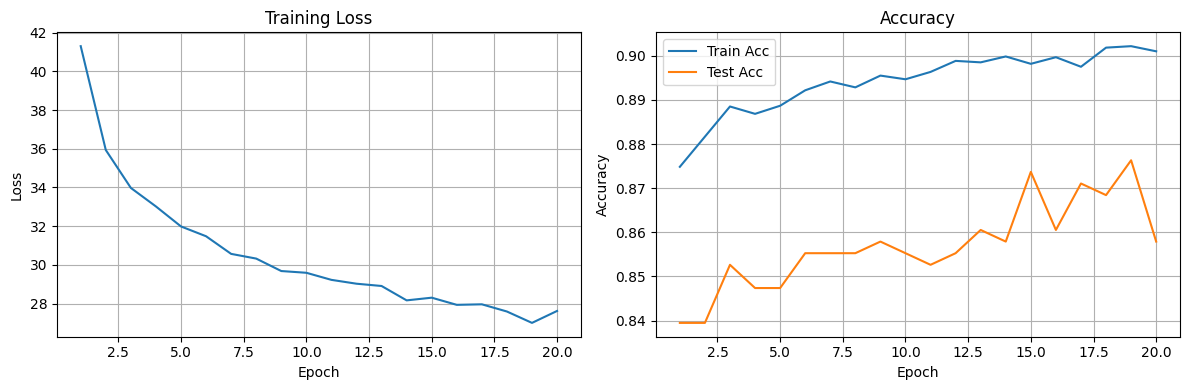

In [13]:
plot_training(history)